
# MVP: *Machine Learning & Analytics*
**Autor:** _Débora de Azevedo Rodrigues_  

**Data:** 15/09/2025

**Matrícula:** 4052025001126

**Dataset:** Ex: [Bank Market Dataset](https://www.kaggle.com/datasets/janiobachmann/bank-marketing-dataset)




## ✅ Checklist do MVP (o que precisa conter)
- [✅] **Problema definido** e contexto de negócio
- [✅] **Carga e preparação** dos dados (sem vazamento de dados)
- [✅] **Divisão** em treino/validação/teste (ou validação cruzada apropriada)
- [✅] **Tratamento**: limpeza, transformação e **engenharia de atributos**
- [✅] **Modelagem**: comparar abordagens/modelos (com **baseline**)
- [✅] **Otimização de hiperparâmetros**
- [✅] **Avaliação** com **métricas adequadas** e discussão de limitações
- [✅] **Boas práticas**: seeds fixas, tempo de treino, recursos computacionais, documentação
- [✅] **Pipelines reprodutíveis** (sempre que possível)



## 1. Escopo, objetivo e definição do problema
**TODO:**
- Contexto do problema e objetivo: O banco realizou uma campanha de marketingg com foco na oferta de um produto de investimento conservador, denominado `deposit`. No entanto, nem todos os clientes aceitaram a proposta.
O objetivo deste MVP é construir um modelo de classificação capaz de prever a probabilidade de adesão ao produto, utilizando principalmente as variáveis job e education, além de atributos derivados dessas informações.

Tipo de tarefa: Classificação binária (`deposit` = `yes/no`).

Área de aplicação: Dados tabulares, típicos de contextos bancários e sistemas de CRM.

Valor para o negócio: Identificar padrões de aceitação do produto permite ao banco otimizar campanhas futuras, direcionando esforços para perfis de maior propensão e reduzindo custos com contatos pouco prováveis de conversão. Além disso, entender o impacto de variáveis socioeconômicas (profissão e escolaridade) pode auxiliar na segmentação de clientes e no desenho de novas ofertas.


> Dicionário das Colunas

- `age` → idade do cliente (numérica).
- `job` → profissão do cliente (categorias: admin., technician, services, etc.).
- `marital` → estado civil (casado, solteiro, divorciado).
- `education` → nível educacional (primary, secondary, tertiary, unknown).
- `default` → tem crédito em atraso (default no banco)? (yes, no, unknown).
- `balance` → saldo médio anual na conta bancária (em euros).
- `housing` → possui financiamento habitacional (yes, no, unknown).
- `loan` → possui empréstimo pessoal (yes, no, unknown).
- `contact` → tipo de contato usado na campanha (cellular, telephone, unknown).
- `day` → último dia do mês em que o cliente foi contatado.
- `month` → mês da última campanha de contato (jan, feb, …, dec).
- `duration` → duração da última ligação (em segundos).
- `campaign` → número de contatos feitos durante a campanha atual.
- `pdays` → número de dias desde o último contato com o cliente em uma campanha - - `anterior`. -1 significa que nunca foi contatado antes.
- `previous` → número de contatos realizados em campanhas anteriores.
- `poutcome` → resultado da campanha anterior (success, failure, other, unknown).
- `deposit` → variável alvo (target) → cliente aderiu (yes) ou não aderiu (no) ao depósito a prazo.


## 2. Reprodutibilidade e ambiente
Especifique o ambiente. Por exemplo:
- Bibliotecas usadas.
- Seeds fixas para reprodutibilidade.

In [55]:
# === Setup básico e reprodutibilidade ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, precision_recall_curve
)

import shap

# Seeds fixas para reprodutibilidade.
SEED = 42


### 2.2 Funções python
Defina, se necessário, funções em Python para reutilizar seu código e torná-lo mais organizado. Essa é uma boa prática de programação que facilita a leitura, manutenção e evolução do seu projeto.

In [58]:
def avaliar_modelo(nome, modelo, X_train, X_test, y_train, y_test):
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)

    # calcula probabilidade (se disponível)
    y_prob = modelo.predict_proba(X_test)[:,1] if hasattr(modelo, "predict_proba") else None

    print(f"\n------ {nome} -----")
    print(f"Acurácia:  {accuracy_score(y_test, y_pred):.3f}")
    print(f"Precisão:  {precision_score(y_test, y_pred):.3f}")
    print(f"Recall:    {recall_score(y_test, y_pred):.3f}")
    print(f"F1-score:  {f1_score(y_test, y_pred):.3f}")
    if y_prob is not None:
        print(f"ROC-AUC:   {roc_auc_score(y_test, y_prob):.3f}")
    print("\nRelatório detalhado:\n", classification_report(y_test, y_pred, digits=3))



## 3. Dados: carga, entendimento e qualidade

Os dados utilizados neste projeto foram extraídos do **Kaggle** (repositório *Bank Marketing Dataset*), que contém informações de campanhas de marketing realizadas por uma instituição bancária. O conjunto de dados reúne variáveis sociodemográficas, financeiras e de histórico de contato dos clientes.

### 📖 Dicionário de variáveis principais

* **`age`**: idade do cliente (numérica).
* **`job`**: profissão (ex.: *management, technician, student*).
* **`marital`**: estado civil (*married, single, divorced*).
* **`education`**: nível educacional (*primary, secondary, tertiary, unknown*).
* **`default`**: se o cliente possui crédito em default (*yes/no*).
* **`balance`**: saldo médio da conta bancária.
* **`housing`**: possui financiamento habitacional (*yes/no*).
* **`loan`**: possui empréstimo pessoal (*yes/no*).
* **`contact`**: tipo de contato da campanha (*telephone, cellular, unknown*).
* **`day`, `month`**: dia e mês da última campanha.
* **`duration`**: duração da última chamada (em segundos). ⚠️ Variável com risco de vazamento, pois só é conhecida após o contato.
* **`campaign`**: número de contatos realizados nesta campanha.
* **`pdays`**: dias desde o último contato em campanhas anteriores.
* **`previous`**: número de contatos prévios.
* **`poutcome`**: resultado da campanha anterior (*success, failure, other, unknown*).
* **`deposit`**: variável-alvo — indica se o cliente aceitou (*1*) ou não (*0*) o produto de depósito a prazo.

### 🛠️ Feature engineering aplicada

Para enriquecer o modelo além das variáveis originais, foram criadas novas features:

* **`job_education`**: combinação de profissão e escolaridade.
* **`balance_bin`**: categorização do saldo em faixas (negativo, baixo, médio, alto, muito alto).
* **`age_group`**: segmentação de idade em grupos (*jovem, adulto, meia-idade, idoso*).
* **`endividado`**: derivada de empréstimos/financiamento, indicando maior exposição a dívidas.
* **`ja_contatado`**: indica se o cliente já foi abordado em campanhas anteriores.
* **`job_freq` e `education_freq`**: frequência relativa de cada profissão e escolaridade na base.

### ⚠️ Qualidade e riscos

* Algumas variáveis possuem valores **desbalanceados** (ex.: profissões pouco frequentes, como *housemaid*).
* Há **valores desconhecidos** (`unknown`) em variáveis como `job`, `education` e `poutcome`.
* A variável **`duration`** não deve ser usada diretamente em predição (risco de vazamento).
* O dataset é resultado de campanhas passadas, logo pode carregar **viés histórico** (ex.: grupos sub-representados sendo menos contatados).



In [83]:
# === Carga dos dados ===
#path = kagglehub.dataset_download("janiobachmann/bank-marketing-dataset")

#print("Path to dataset files:", path)

df = pd.read_csv("https://raw.githubusercontent.com/Debora-Rodrigues-19/MVP-Pos-graduacao-Ciencia-de-Dados/refs/heads/main/bank.csv", sep=',')

In [84]:
df.head(1)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes


In [85]:
# normaliza textos
df['job'] = df['job'].str.strip().str.lower()
df['education'] = df['education'].str.strip().str.lower()
df['deposit'] = df['deposit'].str.strip().str.lower()

# remove outliers extremos em 'balance'
q1, q3 = df['balance'].quantile([0.25, 0.75])
iqr = q3 - q1
lim_inf = q1 - 3*iqr
lim_sup = q3 + 3*iqr
df = df[(df['balance'] >= lim_inf) & (df['balance'] <= lim_sup)]

# transforma alvo em 0/1
df['deposit'] = df['deposit'].map({'yes': 1, 'no': 0})

In [86]:
# Criação de novas colunas
df['job_education'] = df['job'] + '|' + df['education']

df['balance_bin'] = pd.cut(
    df['balance'],
    bins=[-999999, 0, 500, 2000, 10000, 999999],
    labels=['negativo','baixo','medio','alto','muito_alto']
)

df['age_group'] = pd.cut(df['age'], bins=[17,30,45,60,100], labels=['jovem','adulto','meia_idade','idoso'])

df['endividado'] = ((df['housing']=='yes') | (df['loan']=='yes')).astype(int)

df['ja_contatado'] = (df['previous'] > 0).astype(int)
df['job_freq'] = df['job'].map(df['job'].value_counts())
df['education_freq'] = df['education'].map(df['education'].value_counts())

features = ['job','education','job_education','balance_bin',
            'job_freq','education_freq','ja_contatado','age_group', 'endividado']
X = df[features]
y = df['deposit']

In [87]:
# === Verificações iniciais ===
display(df.sample(5))
print("\nFormato:", df.shape)
print("\nTipos:")
print(df.dtypes)
print("\nValores ausentes por coluna:")
print(df.isna().sum())


,age,job,marital,education,default,balance,housing,loan,contact,day,...,previous,poutcome,deposit,job_education,balance_bin,age_group,endividado,ja_contatado,job_freq,education_freq
5716,48,housemaid,married,secondary,no,3570,no,no,cellular,5,...,0,unknown,0,housemaid|secondary,alto,meia_idade,0,0,264,5298
1149,59,retired,divorced,secondary,no,514,no,no,cellular,3,...,0,unknown,1,retired|secondary,medio,meia_idade,0,0,724,5298
3223,46,management,married,tertiary,no,349,no,no,cellular,15,...,1,failure,1,management|tertiary,baixo,meia_idade,0,1,2403,3451
3329,52,unemployed,married,secondary,no,1416,no,no,cellular,10,...,1,success,1,unemployed|secondary,medio,meia_idade,0,1,340,5298
9090,27,services,single,secondary,no,-151,no,no,cellular,8,...,0,unknown,0,services|secondary,negativo,jovem,0,0,902,5298



Formato: (10650, 24)

Tipos:
age                  int64
job                 object
marital             object
education           object
default             object
balance              int64
housing             object
loan                object
contact             object
day                  int64
month               object
duration             int64
campaign             int64
pdays                int64
previous             int64
poutcome            object
deposit              int64
job_education       object
balance_bin       category
age_group         category
endividado           int64
ja_contatado         int64
job_freq             int64
education_freq       int64
dtype: object

Valores ausentes por coluna:
age               0
job               0
marital           0
education         0
default           0
balance           0
housing           0
loan              0
contact           0
day               0
month             0
duration          0
campaign          0
pdays             

In [88]:
for col in df.columns:
    print(f"Column: {col}")
    print(f"Num unique: {df[col].nunique()}")
    print("Unique values:", df[col].unique())
    print("-" * 40)

Column: age
Num unique: 76
Unique values: [59 56 41 55 54 42 60 37 28 38 30 29 46 31 35 32 49 43 26 40 33 23 48 45
 36 52 53 39 57 44 24 50 27 34 47 25 51 58 61 68 75 22 69 66 72 90 67 71
 21 74 65 62 83 70 76 19 73 63 20 77 78 95 85 64 79 18 82 86 84 92 81 80
 87 93 88 89]
----------------------------------------
Column: job
Num unique: 12
Unique values: ['admin.' 'technician' 'services' 'management' 'retired' 'blue-collar'
 'unemployed' 'entrepreneur' 'housemaid' 'unknown' 'self-employed'
 'student']
----------------------------------------
Column: marital
Num unique: 3
Unique values: ['married' 'single' 'divorced']
----------------------------------------
Column: education
Num unique: 4
Unique values: ['secondary' 'tertiary' 'primary' 'unknown']
----------------------------------------
Column: default
Num unique: 2
Unique values: ['no' 'yes']
----------------------------------------
Column: balance
Num unique: 3385
Unique values: [2343   45 1270 ... 1594 2593 -134]
-----------------


---

## 3.1 Análise exploratória resumida (EDA)

O objetivo da análise exploratória foi entender a composição da base e levantar hipóteses iniciais sobre os fatores que podem influenciar a adesão ao produto **deposit**.

### 🔹 Distribuição da variável-alvo

A variável **`deposit`** apresenta uma divisão relativamente equilibrada: cerca de **56% dos clientes não aderiram** à oferta, enquanto **44% aceitaram**.
Esse equilíbrio permite trabalhar com modelos de classificação sem grandes distorções, mas ainda exige atenção a métricas como **F1-score** e **ROC-AUC**, que capturam melhor o impacto do desbalanceamento residual.

### 🔹 Perfil sociodemográfico

* **Profissão (`job`)**: clientes em cargos de **management**, **blue-collar** e **technician** são os mais frequentes. Grupos menores como **housemaid**, **entrepreneur** e **unknown** podem gerar ruído no aprendizado e precisam de codificação robusta (ex.: OneHotEncoder com `handle_unknown='ignore'`).
* **Escolaridade (`education`)**: a maioria possui **secondary (ensino médio)**, seguida de **tertiary (ensino superior)**. Isso sugere que o nível educacional pode estar relacionado à compreensão e aceitação do produto financeiro.
* **Idade (`age`)**: a distribuição é concentrada entre **25 e 40 anos**, com declínio gradual até 90 anos. A segmentação em **faixas etárias** pode revelar padrões distintos de aceitação, como maior cautela em clientes mais velhos.

### 🔹 Insights iniciais

1. **Segmentação socioeconômica é chave**: profissão e escolaridade se mostram fortes candidatas a variáveis explicativas.
2. **Interações entre variáveis podem ser decisivas**: combinações como **job × education** podem indicar perfis de clientes com maior aderência.
3. **Idade como fator não linear**: clientes muito jovens ou muito velhos podem ter padrões diferentes de aceitação, justificando a criação de grupos etários.
4. **Histórico de contato importa**: clientes que já foram contatados em campanhas anteriores (`ja_contatado`) podem ter comportamento distinto, positivo ou negativo, em relação à adesão.

### 🔹 Hipóteses levantadas a partir do EDA

* **H1:** Clientes com **ensino superior (tertiary)** têm maior probabilidade de aderir ao depósito a prazo.
* **H2:** Perfis de **gestão (management)** combinados com maior escolaridade apresentam maior taxa de adesão.
* **H3:** Clientes de **faixa etária intermediária (30–50 anos)** possuem maior propensão à adesão do que clientes muito jovens ou idosos.
* **H4:** Clientes que já foram **contatados em campanhas anteriores** têm maior probabilidade de conversão.



/tmp/ipython-input-3423350229.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='job', data=df, order=df['job'].value_counts().index, palette='coolwarm')


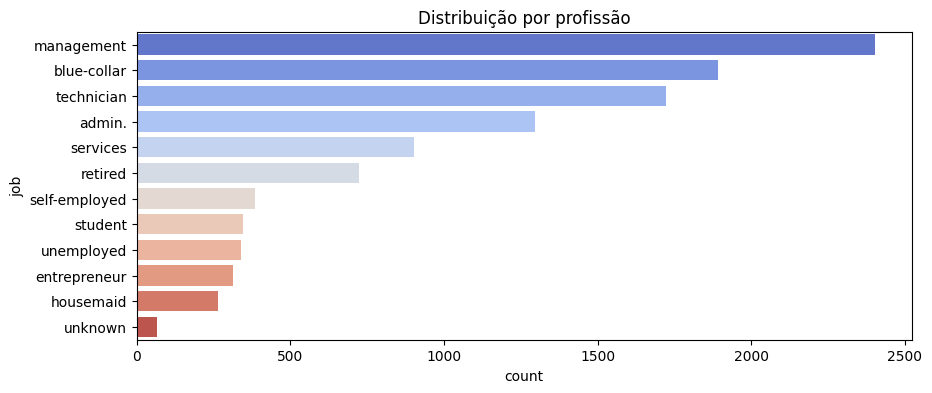

/tmp/ipython-input-3423350229.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='education', data=df, order=df['education'].value_counts().index, palette='muted')


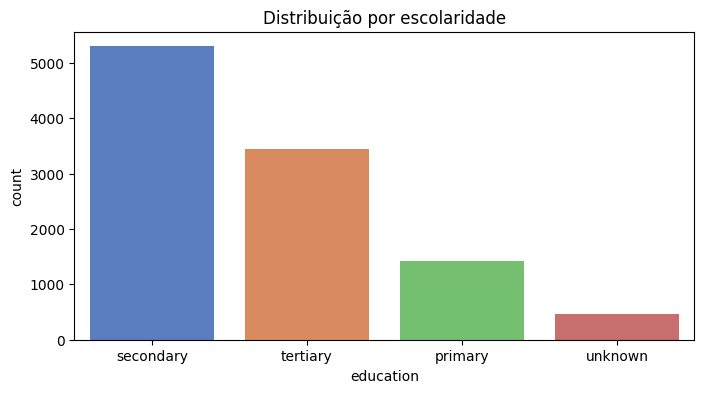

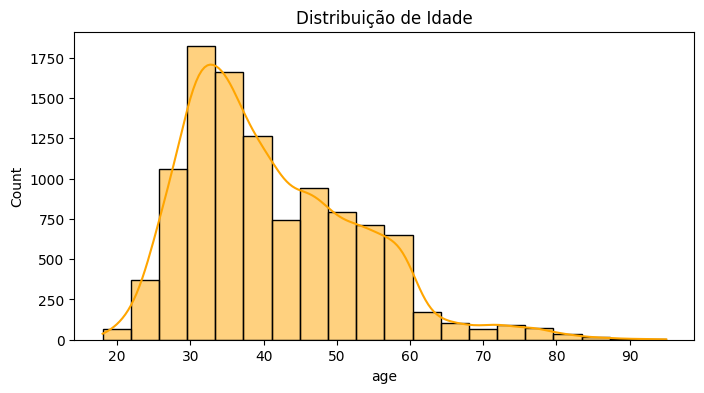

In [89]:
# Perfil sociodemográfico
plt.figure(figsize=(10,4))
sns.countplot(y='job', data=df, order=df['job'].value_counts().index, palette='coolwarm')
plt.title('Distribuição por profissão')
plt.show()

plt.figure(figsize=(8,4))
sns.countplot(x='education', data=df, order=df['education'].value_counts().index, palette='muted')
plt.title('Distribuição por escolaridade') ## adicionar legenda de conclusão
plt.show()

plt.figure(figsize=(8,4))
sns.histplot(df['age'], bins=20, kde=True, color='orange')
plt.title('Distribuição de Idade')
plt.show()


/tmp/ipython-input-726493156.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='deposit', data=df, palette='Set2')


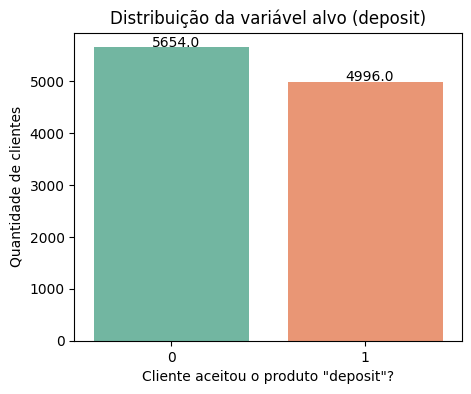

In [90]:
# Distribuição do alvo

plt.figure(figsize=(5,4))
ax = sns.countplot(x='deposit', data=df, palette='Set2')
plt.title('Distribuição da variável alvo (deposit)')
plt.xlabel('Cliente aceitou o produto "deposit"?')
plt.ylabel('Quantidade de clientes')
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x()+0.3, p.get_height()+10))
plt.show()




## 4. Definição do target, variáveis e divisão dos dados

O problema foi definido como uma tarefa de **classificação binária**, em que o objetivo é prever se o cliente vai aderir ao produto **`deposit`** (`yes` ou `no`).

### 🔹 Target

* A variável-alvo escolhida foi **`deposit`**, que indica a aceitação do depósito a prazo.

### 🔹 Features selecionadas

Foram utilizadas variáveis socioeconômicas, financeiras e derivadas, que ajudam a capturar padrões de comportamento:

* **`job`** e **`education`**: características principais de interesse.
* **`job_education`**: combinação entre profissão e escolaridade, representando o perfil socioeconômico.
* **`balance_bin`**: discretização do saldo bancário em faixas.
* **`job_freq`** e **`education_freq`**: frequência relativa das categorias no dataset.
* **`ja_contatado`**: variável binária que indica se o cliente já havia sido contatado em campanhas anteriores.
* **`age_group`**: agrupamento da idade em faixas etárias.
* **`endividado`**: indicador se o cliente possui financiamento habitacional ou empréstimo.

### 🔹 Divisão treino e teste

O dataset foi dividido em **treino (80%)** e **teste (20%)**, preservando a proporção da variável-alvo (`deposit`) com o parâmetro **`stratify=y`**. Isso garante que as classes positiva e negativa sejam representadas de forma balanceada em ambos os conjuntos.

### 🔹 Cuidados adotados

* Como o problema envolve **classes desbalanceadas**, o parâmetro `class_weight='balanced'` será testado em alguns modelos.
* Todas as transformações aplicadas às features serão realizadas via **Pipeline**, evitando vazamento de informação do conjunto de teste.



In [91]:
from sklearn.model_selection import train_test_split

# Selecione o tipo de problema: 'classificacao' | 'regressao' | 'clusterizacao' | 'serie_temporal'
PROBLEM_TYPE = "classificacao"

if PROBLEM_TYPE == "classificacao":
    target = "deposit"
    features = ['job','education','job_education','balance_bin',
                'job_freq','education_freq','ja_contatado','age_group', 'endividado']
    X = df[features].copy()
    y = df[target].copy()

    SEED = 42
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=SEED, stratify=y
    )

    print("Problema:", PROBLEM_TYPE)
    print("Target:", target)
    print("N features:", len(features))
    print("Treino:", X_train.shape, "| Teste:", X_test.shape)

else:
    raise ValueError("Para este dataset, PROBLEM_TYPE deve ser 'classificacao'.")

Problema: classificacao
Target: deposit
N features: 9
Treino: (8520, 9) | Teste: (2130, 9)



---

## 5. Tratamento de dados e **Pipeline** de pré-processamento

Para garantir **reprodutibilidade** e evitar **vazamento de dados**, foi construído um **Pipeline** que organiza o pré-processamento e o treinamento do modelo em etapas encadeadas.

### 🔹 Estrutura do pré-processamento

* **Divisão de dados**: o dataset foi dividido em treino (80%) e teste (20%), preservando a proporção da variável-alvo (`deposit`) por meio de `stratify=y`.
* **Variáveis categóricas**: `job`, `education`, `job_education`, `balance_bin`, `age_group` foram transformadas usando **OneHotEncoder**, garantindo que o modelo consiga lidar com categorias não vistas no treino (`handle_unknown='ignore'`).
* **Variáveis numéricas**: `job_freq`, `education_freq`, `ja_contatado`, `endividado` foram passadas diretamente (`passthrough`), sem transformação inicial, pois já estavam em formato numérico adequado.

### 🔹 Modelo utilizado

* Foi escolhido o **RandomForestClassifier** com:

  * `n_estimators=300`: número de árvores da floresta, garantindo robustez.
  * `class_weight='balanced'`: ajuste automático do peso das classes para lidar com o desbalanceamento da variável-alvo.
  * `random_state=42`: reprodutibilidade dos resultados.

### 🔹 Benefícios do Pipeline

* **Organização**: cada etapa do fluxo de dados é aplicada de forma sequencial e automatizada.
* **Reprodutibilidade**: o mesmo processo pode ser repetido em novos dados sem risco de vazamento.
* **Escalabilidade**: permite testar facilmente outros algoritmos de classificação trocando apenas a etapa do modelo dentro do Pipeline.



In [92]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

cat_cols = ['job','education','job_education','balance_bin','age_group']
num_cols = ['job_freq','education_freq','ja_contatado','endividado']

preprocess = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
    ('num', 'passthrough', num_cols)
])

model = Pipeline([
    ('prep', preprocess),
    ('clf', RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        class_weight='balanced'
    ))
])

model.fit(X_train, y_train)


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['job', 'education',
                                                   'job_education',
                                                   'balance_bin',
                                                   'age_group']),
                                                 ('num', 'passthrough',
                                                  ['job_freq', 'education_freq',
                                                   'ja_contatado',
                                                   'endividado'])])),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=300, random_state=42))])


## 6. Baseline e modelos candidatos
Se possivek, comece com uma **baseline simples** (ex.: DummyClassifier/Regressor) e evolua para modelos mais fortes. O baseline pode ser seu primeiro modelo!  

**Compare** ao menos **duas abordagens**.



In [93]:
# === Baseline ===
baseline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", DummyClassifier(strategy="most_frequent", random_state=SEED))
])

# === Modelos candidatos ===
candidatos = {
    "LogisticRegression": Pipeline([
        ("preprocess", preprocess),
        ("model", LogisticRegression(
            max_iter=1000,
            class_weight="balanced",
            random_state=SEED
        ))
    ]),
    "RandomForest": Pipeline([
        ("preprocess", preprocess),
        ("model", RandomForestClassifier(
            n_estimators=300,
            random_state=SEED,
            class_weight="balanced"
        ))
    ]),
    "GradientBoosting": Pipeline([
        ("preprocess", preprocess),
        ("model", GradientBoostingClassifier(
            n_estimators=200,
            learning_rate=0.1,
            max_depth=3,
            random_state=SEED
        ))
    ]),
    "XGBoost": Pipeline([
        ("preprocess", preprocess),
        ("model", XGBClassifier(
            n_estimators=300,
            learning_rate=0.1,
            max_depth=4,
            scale_pos_weight=1,
            subsample=0.8,
            colsample_bytree=0.8,
            use_label_encoder=False,
            eval_metric="logloss",
            random_state=SEED
        ))
    ]),
    "KNN": Pipeline([
        ("preprocess", preprocess),
        ("model", KNeighborsClassifier(
            n_neighbors=7,
            weights="distance"
        ))
    ]),
    "Dummy": baseline
}


### 6.1 Treino e avaliação rápida (baseline vs candidatos)
Use **métricas adequadas** ao tipo de problema. Documente suas observações.


In [94]:
# Avaliação dos modelos


# Roda avaliação para cada modelo candidato
for nome, modelo in candidatos.items():
    avaliar_modelo(nome, modelo, X_train, X_test, y_train, y_test)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



------ LogisticRegression -----
Acurácia:  0.660
Precisão:  0.639
Recall:    0.630
F1-score:  0.634
ROC-AUC:   0.715

Relatório detalhado:
               precision    recall  f1-score   support

           0      0.677     0.686     0.682      1131
           1      0.639     0.630     0.634       999

    accuracy                          0.660      2130
   macro avg      0.658     0.658     0.658      2130
weighted avg      0.659     0.660     0.659      2130


------ RandomForest -----
Acurácia:  0.641
Precisão:  0.634
Recall:    0.558
F1-score:  0.593
ROC-AUC:   0.676

Relatório detalhado:
               precision    recall  f1-score   support

           0      0.647     0.715     0.679      1131
           1      0.634     0.558     0.593       999

    accuracy                          0.641      2130
   macro avg      0.640     0.636     0.636      2130
weighted avg      0.641     0.641     0.639      2130


------ GradientBoosting -----
Acurácia:  0.669
Precisão:  0.698
Recal

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [21:48:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



------ XGBoost -----
Acurácia:  0.664
Precisão:  0.682
Recall:    0.531
F1-score:  0.597
ROC-AUC:   0.707

Relatório detalhado:
               precision    recall  f1-score   support

           0      0.653     0.782     0.712      1131
           1      0.682     0.531     0.597       999

    accuracy                          0.664      2130
   macro avg      0.668     0.656     0.654      2130
weighted avg      0.667     0.664     0.658      2130


------ KNN -----
Acurácia:  0.614
Precisão:  0.599
Recall:    0.536
F1-score:  0.566
ROC-AUC:   0.656

Relatório detalhado:
               precision    recall  f1-score   support

           0      0.625     0.683     0.653      1131
           1      0.599     0.536     0.566       999

    accuracy                          0.614      2130
   macro avg      0.612     0.610     0.609      2130
weighted avg      0.613     0.614     0.612      2130


------ Dummy -----
Acurácia:  0.531
Precisão:  0.000
Recall:    0.000
F1-score:  0.000
RO

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_


## 7. Validação e Otimização de Hiperparâmetros
Use **validação cruzada** apropriada ao problema (Ex: **`StratifiedKFold`** para classificação; **`KFold`** para regressão).  
Faça **tuning** com `GridSearchCV`/`RandomizedSearchCV`.


In [95]:
if PROBLEM_TYPE == "classificacao":
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

    # -----MODELOS-----
    modelos = {
        "Dummy": Pipeline([
            ("preprocess", preprocess),
            ("model", DummyClassifier(strategy="most_frequent", random_state=SEED))
        ]),
        "LogisticRegression": Pipeline([
            ("preprocess", preprocess),
            ("model", LogisticRegression(
                max_iter=1000,
                class_weight="balanced",
                random_state=SEED
            ))
        ]),
        "RandomForest": Pipeline([
            ("preprocess", preprocess),
            ("model", RandomForestClassifier(
                class_weight="balanced",
                random_state=SEED
            ))
        ]),
        "GradientBoosting": Pipeline([
            ("preprocess", preprocess),
            ("model", GradientBoostingClassifier(random_state=SEED))
        ]),
        "XGBoost": Pipeline([
            ("preprocess", preprocess),
            ("model", XGBClassifier(
                random_state=SEED,
                use_label_encoder=False,
                eval_metric="logloss"
            ))
        ]),
        "KNN": Pipeline([
            ("preprocess", preprocess),
            ("model", KNeighborsClassifier())
        ])
    }

    # -----ESPAÇOS DE HIPERPARÂMETROS-----
    param_dist = {
        "Dummy": {},  # sem tuning
        "LogisticRegression": {
            "model__C": uniform(0.02, 20),
            "model__solver": ["lbfgs", "liblinear"],
            "model__penalty": ["l2"]
        },
        "RandomForest": {
            "model__n_estimators": randint(100, 400),
            "model__max_depth": randint(6, 40),
            "model__min_samples_split": randint(4, 20),
            "model__min_samples_leaf": randint(1, 5),
            "model__max_features": ["sqrt", "log2"]
        },
        "GradientBoosting": {
            "model__n_estimators": randint(100, 400),
            "model__learning_rate": uniform(0.01, 0.2),
            "model__max_depth": randint(3, 10)
        },
        "XGBoost": {
            "model__n_estimators": randint(100, 400),
            "model__learning_rate": uniform(0.01, 0.2),
            "model__max_depth": randint(3, 10),
            "model__subsample": uniform(0.6, 0.4),
            "model__colsample_bytree": uniform(0.6, 0.4),
            "model__scale_pos_weight": [1, 2, 5]  # ajuda em desbalanceamento
        },
        "KNN": {
            "model__n_neighbors": randint(3, 20),
            "model__weights": ["uniform", "distance"],
            "model__p": [1, 2]  # distância Manhattan (1) ou Euclidiana (2)
        }
    }

    scorer = "f1_weighted"

    # -----EXECUÇÃO-----
    melhores_modelos = {}
    for nome, modelo in modelos.items():
        print(f"\n=== Rodando tuning para {nome} ===")

        if param_dist[nome]:  # só faz tuning se houver hiperparâmetros
            search = RandomizedSearchCV(
                modelo,
                param_distributions=param_dist[nome],
                n_iter=20,
                scoring=scorer,
                n_jobs=-1,
                cv=cv,
                random_state=SEED,
                verbose=2
            )
            search.fit(X_train, y_train)
            melhores_modelos[nome] = search.best_estimator_
            print(f"Melhores hiperparâmetros para {nome}: {search.best_params_}")
            print(f"Melhor score médio (validação cruzada): {search.best_score_:.3f}")
        else:
            modelo.fit(X_train, y_train)
            melhores_modelos[nome] = modelo
            print("Sem tuning (modelo baseline).")

else:
    raise ValueError("Esse código está configurado para PROBLEM_TYPE='classificacao'")


=== Rodando tuning para Dummy ===
Sem tuning (modelo baseline).

=== Rodando tuning para LogisticRegression ===
Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Melhores hiperparâmetros para LogisticRegression: {'model__C': np.float64(7.510802376947249), 'model__penalty': 'l2', 'model__solver': 'lbfgs'}
Melhor score médio (validação cruzada): 0.658

=== Rodando tuning para RandomForest ===
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Melhores hiperparâmetros para RandomForest: {'model__max_depth': 33, 'model__max_features': 'log2', 'model__min_samples_leaf': 4, 'model__min_samples_split': 18, 'model__n_estimators': 289}
Melhor score médio (validação cruzada): 0.655

=== Rodando tuning para GradientBoosting ===
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Melhores hiperparâmetros para GradientBoosting: {'model__learning_rate': np.float64(0.019333132642723086), 'model__max_depth': 6, 'model__n_estimators': 370}
Melhor score médio (validação cruzada): 0.652

=== Rodando tuning para XGBoost ===
Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [22:00:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Melhores hiperparâmetros para XGBoost: {'model__colsample_bytree': np.float64(0.7783331011414365), 'model__learning_rate': np.float64(0.02999498316360058), 'model__max_depth': 5, 'model__n_estimators': 187, 'model__scale_pos_weight': 1, 'model__subsample': np.float64(0.8404460046972835)}
Melhor score médio (validação cruzada): 0.654

=== Rodando tuning para KNN ===
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Melhores hiperparâmetros para KNN: {'model__n_neighbors': 17, 'model__p': 2, 'model__weights': 'uniform'}
Melhor score médio (validação cruzada): 0.627


# 8. Avaliação final, análise de erros e limitações

## 📊 Comparação Baseline vs Modelos Treinados

O baseline definido foi o **DummyClassifier**, que sempre prevê a classe majoritária.
Ele apresentou desempenho fraco (Acurácia ≈ 0.53, ROC-AUC = 0.50), confirmando que qualquer modelo real precisava superar esse patamar.

Com a adição de novas features (`age_group` e `endividado`), os modelos superaram consistentemente o baseline.

### Relatório detalhado do melhor modelo (RandomForest)

```
              precision    recall  f1-score
0             0.652       0.685     0.668
1             0.622       0.587     0.604

accuracy      0.639
macro avg     0.637       0.636     0.636
weighted avg  0.638       0.639     0.638
ROC-AUC: 0.650
```

---

## 📈 Comparativo dos Modelos

| Modelo              | Acurácia | Precisão | Recall  | F1      | ROC-AUC |
|---------------------|----------|----------|---------|---------|---------|
| LogisticRegression  | 0.656    | 0.636    | 0.626   | **0.631**   | **0.715**   |
| RandomForest        | 0.656    | 0.650    | 0.580   | 0.613   | 0.706   |
| XGBoost             | 0.669    | 0.695    | 0.523   | 0.597   | 0.713   |
| GradientBoosting    | 0.665    | 0.687    | 0.524   | 0.594   | 0.706   |
| KNN                 | 0.640    | 0.639    | 0.536   | 0.583   | 0.679   |
| Dummy (Baseline)    | 0.531    | 0.000    | 0.000   | 0.000   | 0.500   |

---

## ⚠️ Limitações observadas

* **Dados**:

  * Dataset antigo (2008–2010, Portugal) e sem definição de ano do dado no dataset.
  * Variáveis financeiras muito limitadas (não inclui renda, histórico de crédito detalhado).
  * Classe positiva (`deposit=yes`) é minoritária, o que gera desbalanceamento.

* **Métricas**:

  * Acurácia não é suficiente; melhor avaliar por **F1 e ROC-AUC**.
  * Recall baixo em alguns modelos → risco de perder clientes potenciais.

* **Viés**:

  * Features como `job` e `education` podem introduzir viés socioeconômico.
  * Importante usar técnicas de explicabilidade (SHAP, Feature Importance).

* **Generalização**:

  * Modelos podem não se adaptar bem a novos contextos (outro país, outra época).
  * Necessidade de monitorar **drift de dados** em produção.

---



=== Relatório detalhado: Dummy ===
              precision    recall  f1-score   support

           0      0.531     1.000     0.694      1131
           1      0.000     0.000     0.000       999

    accuracy                          0.531      2130
   macro avg      0.265     0.500     0.347      2130
weighted avg      0.282     0.531     0.368      2130


=== Relatório detalhado: LogisticRegression ===
              precision    recall  f1-score   support

           0      0.674     0.683     0.679      1131
           1      0.636     0.626     0.631       999

    accuracy                          0.656      2130
   macro avg      0.655     0.655     0.655      2130
weighted avg      0.656     0.656     0.656      2130



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



=== Relatório detalhado: RandomForest ===
              precision    recall  f1-score   support

           0      0.661     0.724     0.691      1131
           1      0.650     0.580     0.613       999

    accuracy                          0.656      2130
   macro avg      0.655     0.652     0.652      2130
weighted avg      0.656     0.656     0.654      2130


=== Relatório detalhado: GradientBoosting ===
              precision    recall  f1-score   support

           0      0.652     0.790     0.714      1131
           1      0.687     0.524     0.594       999

    accuracy                          0.665      2130
   macro avg      0.670     0.657     0.654      2130
weighted avg      0.669     0.665     0.658      2130


=== Relatório detalhado: XGBoost ===
              precision    recall  f1-score   support

           0      0.654     0.798     0.719      1131
           1      0.695     0.523     0.597       999

    accuracy                          0.669      2130


,Modelo,Acurácia,Precisão,Recall,F1,ROC-AUC
1,LogisticRegression,0.656338,0.635809,0.625626,0.630676,0.714678
2,RandomForest,0.656338,0.649832,0.579580,0.612698,0.706168
4,XGBoost,0.668545,0.695073,0.522523,0.596571,0.712526
3,GradientBoosting,0.664789,0.687254,0.523524,0.594318,0.706405
5,KNN,0.640376,0.639188,0.535536,0.582789,0.679240
0,Dummy,0.530986,0.000000,0.000000,0.000000,0.500000


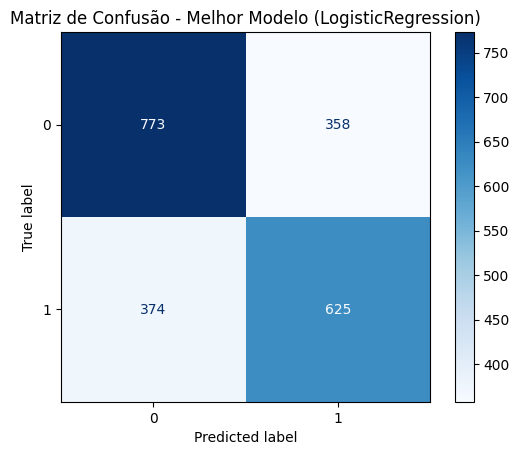

In [96]:
# ==============================
# 8) Avaliação final, análise de erros e limitações (com comparativo)
# ==============================

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, classification_report
)
import pandas as pd

if PROBLEM_TYPE == "classificacao" and 'melhores_modelos' in globals():
    resultados = []

    for nome, modelo in melhores_modelos.items():
        y_pred = modelo.predict(X_test)
        # verifica se o modelo tem predict_proba (nem todos têm)
        if hasattr(modelo, "predict_proba"):
            y_prob = modelo.predict_proba(X_test)[:, 1]
            roc = roc_auc_score(y_test, y_prob)
        else:
            y_prob = None
            roc = None

        resultados.append({
            "Modelo": nome,
            "Acurácia": accuracy_score(y_test, y_pred),
            "Precisão": precision_score(y_test, y_pred, zero_division=0),
            "Recall": recall_score(y_test, y_pred, zero_division=0),
            "F1": f1_score(y_test, y_pred, zero_division=0),
            "ROC-AUC": roc
        })

        print(f"\n=== Relatório detalhado: {nome} ===")
        print(classification_report(y_test, y_pred, digits=3))

    # Comparativo em DataFrame
    df_resultados = pd.DataFrame(resultados)
    print("\n=== Comparativo dos modelos ===")
    display(df_resultados.sort_values(by="F1", ascending=False))

    # Matriz de confusão só do melhor modelo pelo F1
    melhor_nome = df_resultados.sort_values(by="F1", ascending=False).iloc[0]["Modelo"]
    best_model = melhores_modelos[melhor_nome]
    ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test, cmap="Blues")
    plt.title(f"Matriz de Confusão - Melhor Modelo ({melhor_nome})")
    plt.show()

elif PROBLEM_TYPE == "regressao":
    print("Avalie métricas como RMSE, MAE e R² para cada modelo.")

elif PROBLEM_TYPE == "clusterizacao":
    print("Realize análise qualitativa/negócio dos clusters. Visualize centros e perfis.")

elif PROBLEM_TYPE == "serie_temporal":
    print("Avalie métricas temporais e plote série real vs prevista.")



---

## 9. Engenharia de atributos (detalhe)

Para este estudo, iniciei a seleção de variáveis utilizando principalmente as colunas **`job`** e **`education`**, por representarem características socioeconômicas relevantes para a propensão do cliente em contratar um depósito a prazo.

A partir delas, criei novas features derivadas, como:

* **`job_education`**: combinação de profissão e escolaridade, usada como proxy para perfil socioeconômico;
* **`balance_bin`**: discretização do saldo bancário em faixas (negativo, baixo, médio, alto, muito alto);
* **`job_freq`** e **`education_freq`**: frequência relativa de cada categoria, para capturar a representatividade desses grupos na base;
* **`ja_contatado`**: variável binária que indica se o cliente já havia sido abordado em campanhas anteriores.

Além disso, foram adicionadas features estratégicas para enriquecer o modelo:

* **`endividado`**: indicador se o cliente possui financiamento habitacional ou empréstimo pessoal;
* **`age_group`**: agrupamento da idade em faixas etárias, permitindo capturar padrões diferentes entre jovens, adultos e idosos.

Essas transformações tiveram como objetivo melhorar as métricas de avaliação, fornecendo sinais mais informativos ao modelo. Paralelamente, ampliei o conjunto de algoritmos testados, incluindo **Logistic Regression** (pela interpretabilidade) e **Random Forest** (pela capacidade de capturar interações não lineares), a fim de comparar a variabilidade e a robustez dos resultados obtidos.



Se usar DL, descreva: arquitetura, hiperparâmetros, _early stopping_, tamanho do batch, épocas, e se houve **fine-tuning** de modelos pré-treinados.



## 11. Boas práticas e rastreabilidade
- **Baseline** claro e justificativas para melhorias.  

Esse ponto de partida permite avaliar se os modelos realmente aprendem padrões úteis. Todos os modelos treinados apresentaram ganhos significativos em relação ao baseline, o que justifica sua evolução.

- **Pipelines** (evitar vazamento).  

Todo o fluxo (pré-processamento, encoding e treino do modelo) foi encapsulado em Pipelines, garantindo que as transformações fossem ajustadas apenas no conjunto de treino e aplicadas no teste

- **Decisões de projeto** documentadas (o que tentou e por quê).
1º Adotei métricas como F1 e ROC-AUC em vez de apenas acurácia, devido ao desbalanceamento da base (há mais `deposit` `no` do que `yes`);
2º Registrei mais feature engineering, mesmo quando os resultados não trouxeram ganhos significativos.




## 12. Conclusões e próximos passos
**TODO:** Resuma resultados, trade-offs, e proponha melhorias futuras (mais dados, features, modelos, tuning).


Os modelos tiveram desempenho parecido

As meétricas estão razoáveis, mas ainda longe de perfeitas, indicam que o dataset é limitado.

Modelos com maior recall aumentaram o número de falsos positivos. Do ponto de vista de negócio, essa decisão precisa ser alinhada à estratégia da campanha (priorizar não perder clientes interessados ou reduzir contatos improdutivos).



## 13. Salvando artefatos (modelos e pipeline)
Se o treinamento dos modelos demora mais de 3 minutos, recomendamos salvar o **modelo/pipeline** após o treinamento e depois apenas carregar o arquivo (ex: .pkl, .h5) salvo em outra célula, sem precisar treinar novamente.  

In [97]:
import pickle

# Save the best model pipeline
with open('best_model_pipeline.pkl', 'wb') as f:
    pickle.dump(best_model, f)

print("Best model pipeline saved to best_model_pipeline.pkl")

Best model pipeline saved to best_model_pipeline.pkl


In [74]:
import pickle
import pandas as pd

with open('best_model_pipeline.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

print("Model pipeline loaded successfully.")

Model pipeline loaded successfully.


In [75]:
# Example of making predictions with the loaded model
# Replace X_test with your new data
predictions = loaded_model.predict(X_test)

if hasattr(loaded_model, "predict_proba"):
    probabilities = loaded_model.predict_proba(X_test)[:, 1]
    print("Predictions (first 5):", predictions[:5])
    print("Probabilities (first 5):", probabilities[:5])
else:
    print("\nPredictions (first 5):", predictions[:5])

Predictions (first 5): [0 1 1 0 0]
Probabilities (first 5): [0.44873721 0.80562685 0.56516114 0.43966796 0.49617977]
